In [32]:
# Notebook to read in the nexus files and only save the useful stuff to slim the files down
import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re
from collections import Counter

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [33]:
# Load in the hits
hits = pd.read_hdf(f"ATPC_gamma.h5", 'MC/hits')
hits.z = hits.z+3000
display(hits)

,event_id,x,y,z,time,energy,label,particle_id,hit_id
0,0,217.008652,-1337.527710,2726.841797,7.433965,0.000048,GAS,1,0
1,0,-739.586243,-1646.608521,5000.854492,24.238827,0.000187,GAS,1,1
2,0,-739.586304,-1646.608765,5000.854492,24.238871,0.000043,GAS,22,0
3,0,-739.586182,-1646.607422,5000.854492,24.239120,0.000047,GAS,21,0
4,0,-739.586426,-1646.608643,5000.854492,24.238897,0.000021,GAS,20,0
...,...,...,...,...,...,...,...,...,...
1876674,341,764.549561,1149.917603,3608.209229,1.172803,0.000266,GAS,153,0
1876675,341,764.558411,1149.918823,3608.216553,1.173258,0.000034,GAS,153,1
1876676,341,764.560120,1149.917847,3608.227539,1.173707,0.000341,GAS,153,2
1876677,341,764.556702,1149.920654,3608.219971,1.174095,0.000884,GAS,153,3


In [34]:
# Get general info
print("x min", min(hits.x))
print("x max", max(hits.x))
print("y min",min(hits.y))
print("y max",max(hits.y))
print("z min",min(hits.z))
print("z max",max(hits.z))

x min -3000.0
x max 3000.0
y min -3000.0
y max 2999.2119140625
z min 12.230224609375
z max 6000.0


In [35]:
event_hits = hits[hits.event_id == 341]
event_hits["n"] = round(event_hits["energy"]/25e-6) # Number of electrons
display(event_hits)
print(event_hits.energy.sum())
print(event_hits.n.sum())

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_27582/427124639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_hits["n"] = round(event_hits["energy"]/25e-6) # Number of electrons


,event_id,x,y,z,time,energy,label,particle_id,hit_id,n
1871221,341,733.284912,1073.565430,3597.716309,0.888322,0.000140,GAS,1,0,6.0
1871222,341,-1283.886597,2787.567871,2531.417969,25.604826,0.000103,GAS,1,1,4.0
1871223,341,-1283.886475,2787.568115,2531.417969,25.604874,0.000046,GAS,20,0,2.0
1871224,341,-1283.885986,2787.567627,2531.417236,25.605221,0.000021,GAS,19,0,1.0
1871225,341,-1283.887329,2787.567871,2531.417725,25.605013,0.000045,GAS,18,0,2.0
...,...,...,...,...,...,...,...,...,...,...
1876674,341,764.549561,1149.917603,3608.209229,1.172803,0.000266,GAS,153,0,11.0
1876675,341,764.558411,1149.918823,3608.216553,1.173258,0.000034,GAS,153,1,1.0
1876676,341,764.560120,1149.917847,3608.227539,1.173707,0.000341,GAS,153,2,14.0
1876677,341,764.556702,1149.920654,3608.219971,1.174095,0.000884,GAS,153,3,35.0


2.3756003
95080.0


In [36]:
# Create a new DataFrame with duplicated rows, so we can smear each electron by diffusion
new_df = pd.DataFrame(np.repeat(event_hits[["event_id",'x', 'y', 'z']].values, event_hits['n'], axis=0), columns=["event_id",'x', 'y', 'z'])

# Reset the index of the new DataFrame if needed
new_df = new_df.reset_index(drop=True)
display(new_df)

,event_id,x,y,z
0,341.0,733.284912,1073.565430,3597.716309
1,341.0,733.284912,1073.565430,3597.716309
2,341.0,733.284912,1073.565430,3597.716309
3,341.0,733.284912,1073.565430,3597.716309
4,341.0,733.284912,1073.565430,3597.716309
...,...,...,...,...
95075,341.0,764.555420,1149.919922,3608.217285
95076,341.0,764.555420,1149.919922,3608.217285
95077,341.0,764.555420,1149.919922,3608.217285
95078,341.0,764.555420,1149.919922,3608.217285


In [37]:
# Now apply some smearing to each of the electrons
DL = 0.415 # mm / sqrt(cm)
DT = 0.316 # mm / sqrt(cm)

rng = np.random.default_rng()

# Define a function to generate random numbers from Gaussian distribution
def generate_random(row):
    x = row['x'] # mm
    y = row['y'] # mm
    z = row['z'] # mm
    sigma_DL = DL*np.sqrt(z/10.) # mm - Need to check this Eqn. 
    sigma_DT = DT*np.sqrt(z/10.) # mm - Need to check this Eqn. 

    xy = (x, y)
    cov_xy = [[sigma_DT, 0], [0, sigma_DT]]
    
    x_smear, y_smear = rng.multivariate_normal(xy, cov_xy, 1).T
    z_smear = np.random.normal(z, sigma_DL)

    return pd.Series([x_smear[0], y_smear[0], z_smear], index=['x_smear', 'y_smear', 'z_smear'])

# Apply the function to create new columns
new_columns = new_df.apply(generate_random, axis=1)
df = pd.concat([new_df, new_columns], axis=1)
df["energy"] = 25e-6 # MeV

display(df)



,event_id,x,y,z,x_smear,y_smear,z_smear,energy
0,341.0,733.284912,1073.565430,3597.716309,737.415901,1073.469938,3605.102951,0.000025
1,341.0,733.284912,1073.565430,3597.716309,734.417066,1071.996613,3594.338719,0.000025
2,341.0,733.284912,1073.565430,3597.716309,732.280621,1068.233437,3609.407360,0.000025
3,341.0,733.284912,1073.565430,3597.716309,732.339136,1074.002842,3597.202617,0.000025
4,341.0,733.284912,1073.565430,3597.716309,733.293155,1069.665633,3587.376579,0.000025
...,...,...,...,...,...,...,...,...
95075,341.0,764.555420,1149.919922,3608.217285,766.679508,1150.510661,3603.613326,0.000025
95076,341.0,764.555420,1149.919922,3608.217285,765.642250,1146.714151,3592.135466,0.000025
95077,341.0,764.555420,1149.919922,3608.217285,763.316479,1150.904533,3614.539160,0.000025
95078,341.0,764.555420,1149.919922,3608.217285,767.082959,1148.962672,3617.806225,0.000025


In [38]:
# now we are going to rebin the data, same bins for z and different sizes for x any y
# Create the bins ---- 
xmin=-3000
xmax=3000
xbw=10

ymin=-3000
ymax=3000
ybw=10

zmin=0
zmax=6000
zbw=0.118 # 100 ns timing with vd = 1.18 mm/us

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

# display(S_electron[ S_electron["eventid"] == 1 ])

# # Now lets bin the data
df['x_smear'] = pd.cut(x=df['x_smear'], bins=xbins,labels=xbin_c, include_lowest=True)
df['y_smear'] = pd.cut(x=df['y_smear'], bins=ybins,labels=ybin_c, include_lowest=True)
df['z_smear'] = pd.cut(x=df['z_smear'], bins=zbins,labels=zbin_c, include_lowest=True)

display(df)

,event_id,x,y,z,x_smear,y_smear,z_smear,energy
0,341.0,733.284912,1073.565430,3597.716309,735.0,1075.0,3605.077,0.000025
1,341.0,733.284912,1073.565430,3597.716309,735.0,1075.0,3594.339,0.000025
2,341.0,733.284912,1073.565430,3597.716309,735.0,1065.0,3609.443,0.000025
3,341.0,733.284912,1073.565430,3597.716309,735.0,1075.0,3597.171,0.000025
4,341.0,733.284912,1073.565430,3597.716309,735.0,1065.0,3587.377,0.000025
...,...,...,...,...,...,...,...,...
95075,341.0,764.555420,1149.919922,3608.217285,765.0,1155.0,3603.661,0.000025
95076,341.0,764.555420,1149.919922,3608.217285,765.0,1145.0,3592.097,0.000025
95077,341.0,764.555420,1149.919922,3608.217285,765.0,1155.0,3614.517,0.000025
95078,341.0,764.555420,1149.919922,3608.217285,765.0,1145.0,3617.821,0.000025


In [39]:
# Merge any duplicate rows and sum their energy
# also rename everything back to normal x,y,z
df = df.drop(columns=['x', 'y', 'z'])
df = df.rename(columns={'x_smear': 'x'})
df = df.rename(columns={'y_smear': 'y'})
df = df.rename(columns={'z_smear': 'z'})

# Create a list of tuples representing each row in the DataFrame
rows_as_tuples = [tuple(row) for row in df.values]

# Use Counter to count the occurrences of each row
row_counts = Counter(rows_as_tuples)

# Map the counts back to the DataFrame
df['duplicates'] = [row_counts[tuple(row)] for row in df.values]

# Multiply 'energy' and 'duplicates' columns
df['energy'] = df['energy'] * df['duplicates']

# Drop the 'duplicates' column
df.drop(columns=['duplicates'], inplace=True)

df = df.drop_duplicates()
display(df)

,event_id,x,y,z,energy
0,341.0,735.0,1075.0,3605.077,0.000025
1,341.0,735.0,1075.0,3594.339,0.000050
2,341.0,735.0,1065.0,3609.443,0.000025
3,341.0,735.0,1075.0,3597.171,0.000050
4,341.0,735.0,1065.0,3587.377,0.000025
...,...,...,...,...,...
95065,341.0,765.0,1145.0,3616.405,0.000025
95067,341.0,765.0,1145.0,3607.791,0.000025
95073,341.0,765.0,1145.0,3600.947,0.000025
95076,341.0,765.0,1145.0,3592.097,0.000025


In [40]:
df = df.sort_values(by=['event_id', 'z', 'x', 'y'])

df['event_id'] = df['event_id'].astype(int)
df['z'] = df['z'].astype('float32')
df['x'] = df['x'].astype('float32')
df['y'] = df['y'].astype('float32')
# df['energy'] = df['energy']*1e6
df['energy'] = df['energy'].astype('float32')

display(df)

# with pd.HDFStore(f"../data/nexus/rebinning/test_event.h5", mode='w', complevel=5, complib='zlib') as store:
#     # Write each DataFrame to the file with a unique key
#     store.put('hits', df, format='table')

,event_id,x,y,z,energy
4253,341,-1285.0,2785.0,2511.217041,0.000025
3416,341,-1275.0,2785.0,2511.452881,0.000025
4304,341,-1275.0,2785.0,2511.571045,0.000025
3988,341,-1285.0,2785.0,2512.160889,0.000025
4100,341,-1285.0,2785.0,2512.633057,0.000025
...,...,...,...,...,...
57633,341,-925.0,1705.0,4283.104980,0.000025
69232,341,-925.0,1705.0,4283.340820,0.000025
69218,341,-915.0,1705.0,4283.340820,0.000025
57387,341,-915.0,1705.0,4284.875000,0.000025


In [46]:
%matplotlib widget
# Make a 3D view of the track
fig  = plt.figure(figsize=(10, 10))

# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

fig.set_facecolor('black')
ax.set_facecolor('black')
# ax.scatter(df.x, df.y,  df.z,c= df.energy, cmap='Spectral', s=0.1, label = "reco hits")
ax.scatter(event_hits.x, event_hits.y,  event_hits.z,c= event_hits.energy, cmap='Spectral', s=1, label = "reco hits")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Remove background (axis)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

legend = plt.legend(facecolor = "black")

# Set the text color of the legend
for text in legend.get_texts():
    text.set_color('white')  # Set the text color to red

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyError: 'default'

KeyError: 'default'

In [42]:
plt.figure()

plt.scatter(new_df.z, new_df.x, s=0.5)
plt.xlabel("z [mm]")
plt.ylabel("x [mm]")
# plt.ylim(1210, 1240)
# plt.xlim(4040, 4140)

plt.figure()

plt.scatter(df.z, df.x, s=0.5)
plt.xlabel("z [mm]")
plt.ylabel("x [mm]")
plt.ylim(1210, 1240)
plt.xlim(4040, 4140)
plt.scatter(new_df.z, new_df.x, s=0.5, color = "red")
plt.xlabel("z [mm]")
plt.ylabel("x [mm]")
# plt.ylim(1210, 1240)
# plt.xlim(4040, 4140)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'x [mm]')

KeyError: 'default'

In [43]:
test = pd.read_hdf(f"../data/nexus/rebinning_merge/xesphere_1bar_bb_merge.h5", 'hits')
display(test)


,event_id,x,y,z,energy
0,100,552.5,889.5,5401.312500,0.000025
1,100,679.5,983.5,5403.472656,0.000025
2,100,673.5,985.5,5404.672363,0.000025
3,100,680.5,991.5,5405.962402,0.000025
4,100,540.5,889.5,5408.692383,0.000025
...,...,...,...,...,...
392672422,1099,-267.5,-1907.5,7150.762695,0.000025
392672423,1099,-274.5,-1926.5,7154.842285,0.000025
392672424,1099,-271.5,-1908.5,7155.682617,0.000025
392672425,1099,-283.5,-1926.5,7158.292480,0.000025


KeyError: 'default'

FileNotFoundError: File ../data/nexus/rebinning_merge/xesphere_1bar_bb_merge.h5 does not exist

KeyError: 'default'

FileNotFoundError: File ../data/nexus/rebinning_merge/xesphere_1bar_bb_merge.h5 does not exist

3979


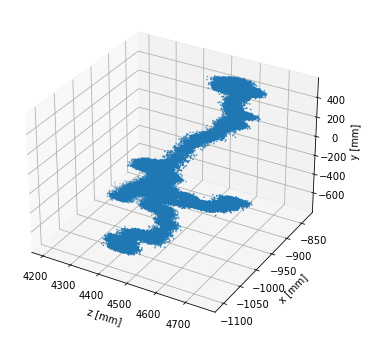

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
ax.set_zlabel('y [mm]')

fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('white')  # Set the background color to white

event_test = test[test.event_id == 103]

p = ax.scatter(event_test.z,event_test.x,event_test.y, s=0.5)

print(len(test.event_id.unique()))

(array([ 1.,  0.,  3.,  6., 15., 13., 12.,  4.,  1.,  1.]),
 array([4233.1875, 4243.8555, 4254.5234, 4265.1914, 4275.8594, 4286.5273,
        4297.196 , 4307.864 , 4318.5317, 4329.1997, 4339.8677],
       dtype=float32),
 <BarContainer object of 10 artists>)

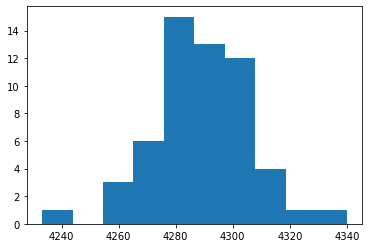

In [ ]:
# bin_min=-5700
# bin_max=5700
# bw=1

# xbins = np.arange(bin_min, bin_max+bw, bw)
# ybins = xbins

xbins = event_test.x.unique()
ybins = event_test.y.unique()

# for x in xbins:
#     for y in ybins:
#         slice_ = event_test[ (event_test.x == x) & (event_test.y == y)]
#         if (len(slice_) > 50):
#              display(slice_)
#              break

        # display(slice_)
        # break


slice_ = event_test[ (event_test.x == -895.5) & (event_test.y == -477.5)]

plt.hist(slice_.z)

